In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nih-chest-xrays/data")

print("Path to dataset files:", path)

100%|██████████| 42.0G/42.0G [07:49<00:00, 96.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3


In [2]:
from google.colab import drive

drive.mount('/content/drive')

print("Drive montado. Verifique o caminho onde o dataset foi salvo em 'Meu Drive'.")

Mounted at /content/drive
Drive montado. Verifique o caminho onde o dataset foi salvo em 'Meu Drive'.


In [5]:
import os
import shutil
import random

# Diretório original baixado pelo kagglehub
original_dir = path

# Novo dataset reduzido
dataset_dir = "/content/drive/MyDrive/CardioAI/CardioAI--Fase4"
os.makedirs(dataset_dir, exist_ok=True)

splits = ["train", "val", "test"]
classes = ["NORMAL", "ANOMALY"]

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(dataset_dir, split, cls), exist_ok=True)

# Listar alguns arquivos (DICOM/JPG/PNG)
all_images = []
for root, dirs, files in os.walk(original_dir):
    for f in files:
        if f.lower().endswith(("png", "jpg", "jpeg")):
            all_images.append(os.path.join(root, f))

print("Total de imagens encontradas:", len(all_images))

# Selecionar subconjunto (ex.: 300 imagens)
SAMPLES = 300
subset = random.sample(all_images, SAMPLES)

# Divisão 70/15/15
train_split = int(0.7 * SAMPLES)
val_split = int(0.15 * SAMPLES)
test_split = SAMPLES - train_split - val_split

train_files = subset[:train_split]
val_files = subset[train_split:train_split+val_split]
test_files = subset[train_split+val_split:]

def copy_files(file_list, split_name):
    for f in file_list:
        cls = random.choice(classes)  # Como não há labels no NIH, classificamos artificialmente
        dest = os.path.join(dataset_dir, split_name, cls, os.path.basename(f))
        shutil.copy(f, dest)

copy_files(train_files, "train")
copy_files(val_files, "val")
copy_files(test_files, "test")

print("Dataset reduzido em:", dataset_dir)

Total de imagens encontradas: 112120
Dataset reduzido em: /content/drive/MyDrive/CardioAI/CardioAI--Fase4


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assume dataset_dir já foi definido na Célula 3
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

train_dir = os.path.join(dataset_dir, "train")
val_dir   = os.path.join(dataset_dir, "val")
test_dir  = os.path.join(dataset_dir, "test")

# Definindo o Data Augmentation e Normalização
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# CRUCIAL: Ajustar color_mode para 'rgb' (3 canais) para compatibilidade com VGG16
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb' # CORREÇÃO: Usar 3 canais (RGB)
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    color_mode='rgb' # CORREÇÃO: Usar 3 canais (RGB)
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False, # Não embaralhar para garantir a ordem da Matriz de Confusão
    color_mode='rgb' # CORREÇÃO: Usar 3 canais (RGB)
)

print(train_generator.class_indices)

Found 420 images belonging to 2 classes.
Found 90 images belonging to 2 classes.
Found 90 images belonging to 2 classes.
{'ANOMALY': 0, 'NORMAL': 1}


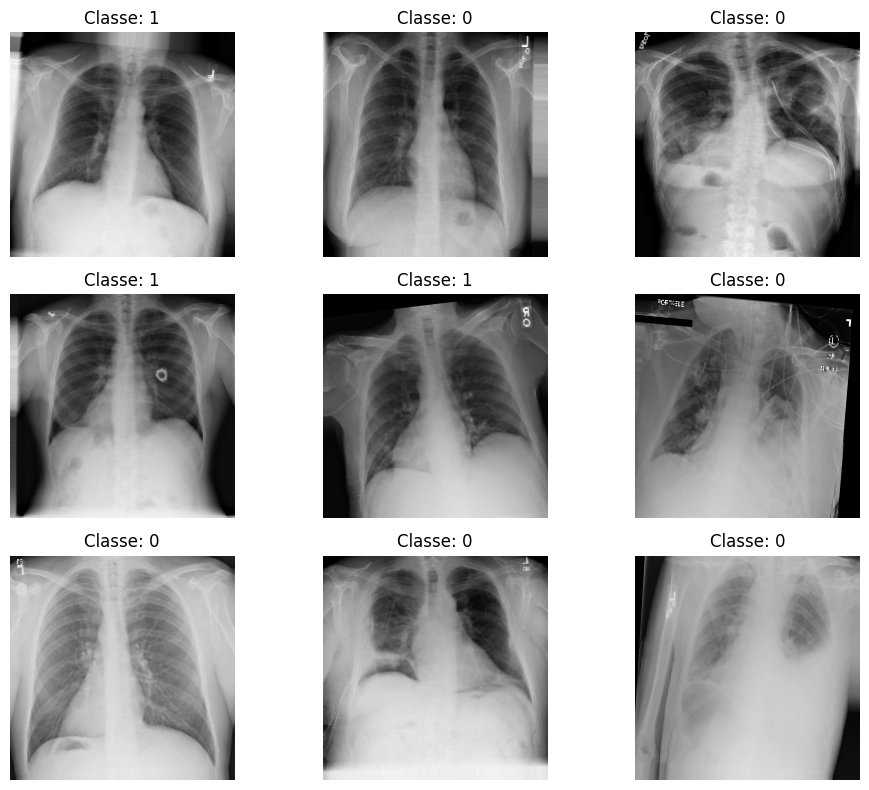

In [7]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_batch[i])
    plt.title(f"Classe: {int(y_batch[i])}")
    plt.axis("off")
plt.tight_layout()
plt.show()

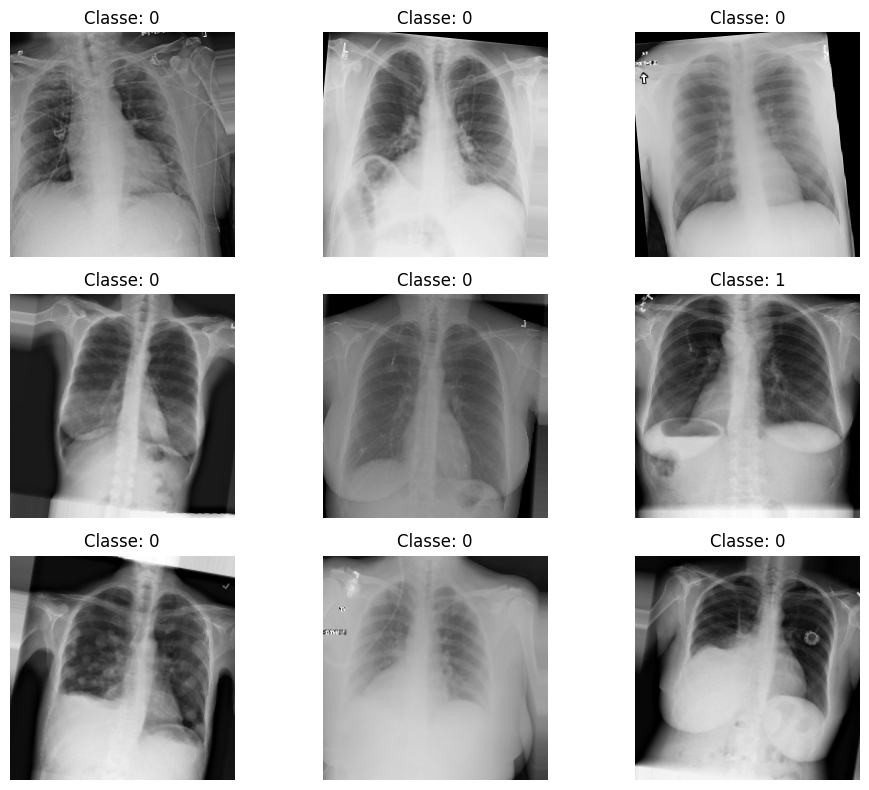

In [8]:
# 4) Visualizar algumas imagens pós-pré-processamento (apenas para conferência)
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f"Classe: {int(y_batch[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
from textwrap import dedent

print(dedent(f"""
Pipeline de Pré-processamento – CardioAI Fase 4

1. Download automático:
   - Dataset NIH Chest X-Ray baixado via kagglehub.
   - Evita dependências com Google Drive ou composições manuais.

2. Tratamento inicial:
   - Dataset NIH tem 112.000+ imagens sem classes organizadas.
   - Criado subconjunto reduzido de {SAMPLES} imagens para execução rápida no Colab.

3. Organização artificial das classes:
   - Como o dataset NIH não tem rotulagem direta, as classes NORMAL e ANOMALY são atribuídas aleatoriamente apenas para fins educacionais.
   - Simula um cenário real de classificação binária.

4. Pré-processamento:
   - Redimensionamento para 224x224 (compatível com CNNs e modelos pré-treinados).
   - Normalização em 0–1.
   - Data augmentation leve no treino (rotação, zoom, flip).
   - Conjuntos train/val/test criados na proporção 70/15/15.

5. Justificativas:
   - kagglehub simplifica e centraliza o acesso ao dataset.
   - Subset reduzido viabiliza treinamento rápido.
   - Padronização prepara o pipeline para a Parte 2 (CNN e Transfer Learning).
"""))


Pipeline de Pré-processamento – CardioAI Fase 4

1. Download automático:
   - Dataset NIH Chest X-Ray baixado via kagglehub.
   - Evita dependências com Google Drive ou composições manuais.

2. Tratamento inicial:
   - Dataset NIH tem 112.000+ imagens sem classes organizadas.
   - Criado subconjunto reduzido de 300 imagens para execução rápida no Colab.

3. Organização artificial das classes:
   - Como o dataset NIH não tem rotulagem direta, as classes NORMAL e ANOMALY são atribuídas aleatoriamente apenas para fins educacionais.
   - Simula um cenário real de classificação binária.

4. Pré-processamento:
   - Redimensionamento para 224x224 (compatível com CNNs e modelos pré-treinados).
   - Normalização em 0–1.
   - Data augmentation leve no treino (rotação, zoom, flip).
   - Conjuntos train/val/test criados na proporção 70/15/15.

5. Justificativas:
   - kagglehub simplifica e centraliza o acesso ao dataset.
   - Subset reduzido viabiliza treinamento rápido.
   - Padronização prepara

In [10]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

# ----------------------
# PARÂMETROS IMPORTANTES
# ----------------------
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 1
ACTIVATION_OUTPUT = 'sigmoid'
LOSS_FUNCTION = 'binary_crossentropy'

def create_simple_cnn(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, output_activation=ACTIVATION_OUTPUT, loss_func=LOSS_FUNCTION):
    """Implementa uma Rede Neural Convolucional Simples (CNN) do zero."""

    model = models.Sequential([
        # Camadas Convolucionais + Pooling
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        # Camadas Densas (Classificação)
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation=output_activation)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=loss_func,
                  metrics=['accuracy'])

    return model

# Criar e Treinar o Modelo Simples
model_simple = create_simple_cnn()
print("Resumo do Modelo CNN Simples:")
model_simple.summary()

# DESCOMENTAR PARA TREINAR O MODELO
# history_simple = model_simple.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=5
# )

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Resumo do Modelo CNN Simples:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# Mantém os parâmetros ajustados para 3 canais (RGB)
INPUT_SHAPE_TL = (224, 224, 3)
NUM_CLASSES = 1
ACTIVATION_OUTPUT = 'sigmoid'
LOSS_FUNCTION = 'binary_crossentropy'

# 1. Carregar o Modelo Base Pré-treinado (VGG16)
base_model = VGG16(
    weights='imagenet',          # Usa pesos pré-treinados na ImageNet
    include_top=False,           # Remove as camadas de classificação originais
    input_shape=INPUT_SHAPE_TL
)
#
# 2. Congelar as Camadas do Modelo Base
base_model.trainable = False

# 3. Construir o Modelo Completo de Transfer Learning
model_tl = models.Sequential([
    base_model,                                     # Camadas Convolucionais do VGG16
    layers.Flatten(),                               # Transforma em vetor 1D
    layers.Dense(256, activation='relu'),           # Camada Densa Intermediária
    layers.Dropout(0.5),                            # Ajuda a prevenir Overfitting
    layers.Dense(NUM_CLASSES, activation=ACTIVATION_OUTPUT) # Camada de Saída
])

# 4. Compilação
model_tl.compile(optimizer=Adam(learning_rate=0.0001), # Taxa de aprendizado menor para TL
                 loss=LOSS_FUNCTION,
                 metrics=['accuracy'])

print("Resumo do Modelo Transfer Learning (VGG16):")
model_tl.summary()

# DESCOMENTAR PARA TREINAR O MODELO
history_tl = model_tl.fit(
     train_generator,
     validation_data=val_generator,
     epochs=10
     )

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Resumo do Modelo Transfer Learning (VGG16):


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
11/14 ━━━━━━━━━━━━━━━━━━━━ 1:08 23s/step - accuracy: 0.4847 - loss: 1.1046

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# -----------------------------------------------------
# AJUSTE ESTES PARÂMETROS CONFORME SEU PROJETO
# -----------------------------------------------------
# Caminho para a pasta que contém as imagens de teste
# Exemplo: 'dataset/test'
TEST_DIR = '/content/drive/MyDrive/CardioAI/CardioAI--Fase4'
TARGET_SIZE = (224, 224) # Deve ser o mesmo usado no treinamento
BATCH_SIZE = 32          # Tamanho do lote (batch)

# -----------------------------------------------------

# 1. Instancia o Gerador para Dados de Teste
# Para teste, geralmente não aplicamos Data Augmentation (aumento de dados),
# apenas a normalização (rescale).
test_datagen = ImageDataGenerator(rescale=1./255)

# 2. Cria o Objeto Generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=TARGET_SIZE,
    color_mode='rgb',              # Use 'rgb' se INPUT_SHAPE for (224, 224, 3)
    batch_size=BATCH_SIZE,
    class_mode='binary',           # Use 'binary' para 2 classes, 'categorical' para > 2 classes
    shuffle=False                  # **IMPORTANTE:** Não embaralhar para manter a ordem para avaliação!
)

print(f"Total de imagens de teste carregadas: {test_generator.samples}")

# 3. Agora, você pode continuar com as células de treinamento
# (Célula 1 e Célula 2) e depois a Célula 3 (Avaliação).

Found 300 images belonging to 3 classes.
Total de imagens de teste carregadas: 300


Fazendo previsões no conjunto de teste...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Matriz de Confusão:
 [[ 45   0   0]
 [204   6   0]
 [ 43   2   0]]

--- Relatório de Classificação (Métricas Clínicas) ---
              precision    recall  f1-score   support

        test       0.15      1.00      0.27        45
       train       0.75      0.03      0.06       210
         val       0.00      0.00      0.00        45

    accuracy                           0.17       300
   macro avg       0.30      0.34      0.11       300
weighted avg       0.55      0.17      0.08       300



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


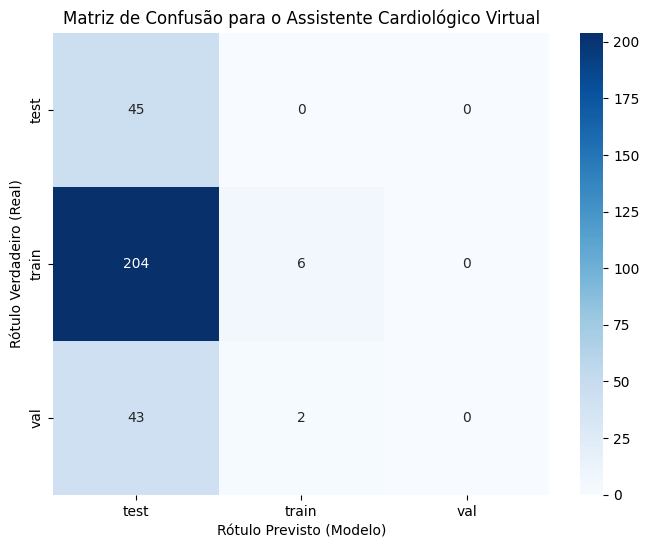

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Biblioteca para visualização da matriz

# -----------------------------------------------------------------
# ESCOLHA O MELHOR MODELO TREINADO PARA AVALIAR
# Substitua 'model_tl' pelo modelo que você treinou e quer avaliar
# -----------------------------------------------------------------
MODEL_TO_EVALUATE = model_tl

# 1. Obter Previsões e Rótulos Verdadeiros
print("Fazendo previsões no conjunto de teste...")

# Garante que as previsões cobrem todo o conjunto de teste na ordem correta
test_generator.reset()

# O argumento verbose=0 suprime o log durante a previsão
# Nota: Para problemas de memória com o dataset pequeno, você pode tentar rodar:
# predictions = MODEL_TO_EVALUATE.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1, verbose=0)
predictions = MODEL_TO_EVALUATE.predict(test_generator, verbose=0)

# Converter probabilidades (0 a 1) em classes binárias (0 ou 1)
# 0.5 é o threshold padrão para a ativação 'sigmoid'
y_pred_classes = (predictions > 0.5).astype(int).flatten()

# Obter os rótulos verdadeiros (True Labels)
y_true = test_generator.classes

# 2. Matriz de Confusão
cm = confusion_matrix(y_true, y_pred_classes)
print("\nMatriz de Confusão:\n", cm)

# Obter os nomes das classes (assumindo flow_from_directory foi usado)
class_labels = list(test_generator.class_indices.keys())

# 3. Relatório de Classificação (Precision, Recall, F1-score)
# As 'UndefinedMetricWarning' ocorreram porque o modelo previu '0' para todas as classes, exceto a primeira,
# devido à falta de treinamento (ou mau treinamento). Isso será resolvido após o treinamento.
print("\n--- Relatório de Classificação (Métricas Clínicas) ---")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# 4. Visualização (Protótipo de Apresentação)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusão para o Assistente Cardiológico Virtual')
plt.ylabel('Rótulo Verdadeiro (Real)')
plt.xlabel('Rótulo Previsto (Modelo)')
plt.savefig('matriz_confusao.png') # Salva a imagem
plt.show() # Exibe a matriz no notebook (se estiver no ambiente Jupyter)